### 合并特征
对之前生成的各项特征进行合并产生最终的特征空间

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.display import display

首先将之前根据用户分组的统计特征合并起来，然后将其与按照用户-拍卖场结对分组的特征合并起来，最后加上时间特征，分别于训练集、测试集连接生成后续进行训练和预测的特征数据文件

In [62]:
def merge_data():    
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    time_differences = pd.read_csv('tdiff.csv', index_col=0)
    bids_auc = pd.read_csv('bids_auc.csv')

    bids_auc = bids_auc.groupby('bidder_id').mean()
    
    bidders = pd.read_csv('cnt_bidder.csv', index_col=0)
    country_cate = pd.read_csv('coun_cate.csv', index_col=0)
    bidder_inv = pd.read_csv('bidder_inv.csv', index_col=0)
    bidders = bidders.merge(country_cate, right_index=True, left_index=True)
    bidders = bidders.merge(bidder_inv, right_index=True, left_index=True)

    bidders = bidders.merge(bids_auc, right_index=True, left_index=True)
    bidders = bidders.merge(time_differences, right_index=True,
                            left_index=True)

    train = train.merge(bidders, left_on='bidder_id', right_index=True)
    train.to_csv('train_full.csv', index=False)

    test = test.merge(bidders, left_on='bidder_id', right_index=True)
    test.to_csv('test_full.csv', index=False)    

In [63]:
merge_data()

In [2]:
train_full = pd.read_csv('train_full.csv')
test_full = pd.read_csv('test_full.csv')
print train_full.shape
print test_full.shape

(1983, 445)
(4626, 444)


In [3]:
train_full['outcome'] = train_full['outcome'].astype(int)
ytrain = train_full['outcome']
train_full.drop('outcome', 1, inplace=True)

test_ids = test_full['bidder_id']

labels = ['payment_account', 'address', 'bidder_id']
train_full.drop(labels=labels, axis=1, inplace=True)
test_full.drop(labels=labels, axis=1, inplace=True)

### 设计交叉验证

### 模型选择
根据之前的分析，由于当前的数据集中存在正负例不均衡的问题，所以考虑选取了RandomForestClassfier, GradientBoostingClassifier, xgboost, lightgbm等四种模型来针对数据及进行训练和预测，确定最终模型的基本思路如下：
* 对四个模型分别使用评价函数roc_auc进行交叉验证并绘制auc曲线，对各个模型的多轮交叉验证得分取平均值并输出
* 根据得分确定最终选用的一个或多个模型
 * 若最后发现一个模型的表现大幅度优于其他所有模型，则选择该模型进一步调参
 * 若最后发现多个模型表现都不错，则进行模型的集成，得到聚合模型
 * 使用GridSearchCV来从人为设定的参数列表中选择最佳的参数组合确定最终的模型

In [10]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

# from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

def kfold_plot(train, ytrain, model):
#     kf = StratifiedKFold(y=ytrain, n_folds=5)
    kf = StratifiedKFold(n_splits=5)
    scores = []
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    exe_time = []
    
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue'])
    lw = 2
    
    i=0
    for (train_index, test_index), color in zip(kf.split(train, ytrain), colors):
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        begin_t = time.time()
        predictions = model(X_train, X_test, y_train)
        end_t = time.time()
        exe_time.append(round(end_t-begin_t, 3))
#         model = model
#         model.fit(X_train, y_train)    
#         predictions = model.predict_proba(X_test)[:, 1]        
        scores.append(roc_auc_score(y_test.astype(float), predictions))        
        fpr, tpr, thresholds = roc_curve(y_test, predictions)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
    
    mean_tpr /= kf.get_n_splits(train, ytrain)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
#     print 'scores: ', scores
    print 'mean scores: ', np.mean(scores)
    print 'mean model process time: ', np.mean(exe_time), 's'
    
    return scores, np.mean(scores), np.mean(exe_time)

收集各个模型进行交叉验证的结果包括每轮交叉验证的auc得分、auc的平均得分以及模型的训练时间

In [11]:
dct_scores = {}
mean_score = {}
mean_time = {}

#### RandomForestClassifier

In [5]:
from sklearn.model_selection import GridSearchCV
import time

In [6]:
from sklearn.ensemble import RandomForestClassifier

def forest_model(X_train, X_test, y_train):
#     begin_t = time.time()
    model = RandomForestClassifier(n_estimators=160, max_features=35, max_depth=8, random_state=7)
    model.fit(X_train, y_train)    
#     end_t = time.time()
#     print 'train time of forest model: ',round(end_t-begin_t, 3), 's'
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

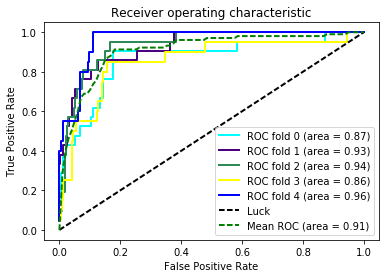

mean scores:  0.909571935157
mean model process time:  0.643 s


In [12]:
dct_scores['forest'], mean_score['forest'], mean_time['forest'] = kfold_plot(train_full, ytrain, forest_model)
# kfold_plot(train_full, ytrain, model_forest)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
def gradient_model(X_train, X_test, y_train):
    model = GradientBoostingClassifier(n_estimators=200, random_state=7, max_depth=5, learning_rate=0.03)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

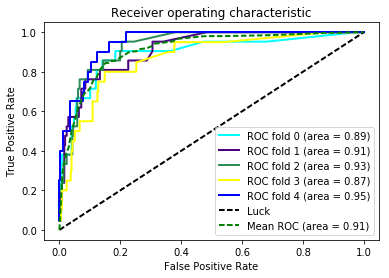

mean scores:  0.911847771023
mean model process time:  4.1948 s


In [15]:
dct_scores['gbm'], mean_score['gbm'], mean_time['gbm'] = kfold_plot(train_full, ytrain, gradient_model)

In [16]:
import xgboost as xgb
def xgboost_model(X_train, X_test, y_train):
    X_train = xgb.DMatrix(X_train.values, label=y_train.values)
    X_test = xgb.DMatrix(X_test.values)
    params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': 1, 'seed': 7,
              'max_depth': 6, 'eta': 0.01}    
    model = xgb.train(params, X_train, 600)
    predictions = model.predict(X_test)
    return predictions

/home/lancelot/anaconda2/envs/udacity/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


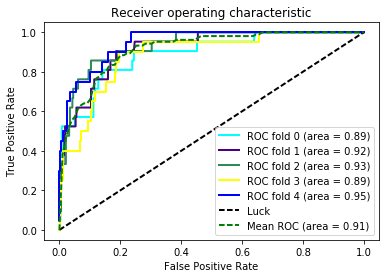

mean scores:  0.915372340426
mean model process time:  3.1482 s


In [17]:
dct_scores['xgboost'], mean_score['xgboost'], mean_time['xgboost'] = kfold_plot(train_full, ytrain, xgboost_model)

In [18]:
import lightgbm as lgb
def lightgbm_model(X_train, X_test, y_train):
    X_train = lgb.Dataset(X_train.values, y_train.values)
    params = {'objective': 'binary', 'metric': {'auc'}, 'learning_rate': 0.01, 'max_depth': 6, 'seed': 7}
    model = lgb.train(params, X_train, num_boost_round=600)
    predictions = model.predict(X_test)
    return predictions

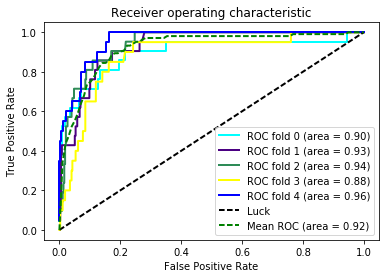

mean scores:  0.921512158055
mean model process time:  0.3558 s


In [19]:
dct_scores['lgbm'], mean_score['lgbm'], mean_time['lgbm'] = kfold_plot(train_full, ytrain, lightgbm_model)

### 模型比较
比较四个模型在交叉验证机上的roc_auc平均得分和模型训练的时间

In [40]:
def plot_model_comp(title, y_label, dct_result):
    data_source = dct_result.keys()
    y_pos = np.arange(len(data_source))
    # model_auc = [0.910, 0.912, 0.915, 0.922]
    model_auc = dct_result.values()
    barlist = plt.bar(y_pos, model_auc, align='center', alpha=0.5)
    # get the index of highest score
    max_val = max(model_auc)
    idx = model_auc.index(max_val)
    barlist[idx].set_color('r')
    plt.xticks(y_pos, data_source)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    print 'The highest auc score is {0} of model: {1}'.format(max_val, data_source[idx])

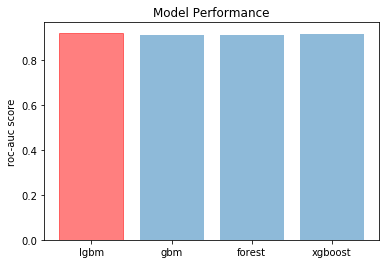

The highest auc score is 0.921512158055 of model: lgbm


In [41]:
plot_model_comp('Model Performance', 'roc-auc score', mean_score)

In [42]:
def plot_time_comp(title, y_label, dct_result):
    data_source = dct_result.keys()
    y_pos = np.arange(len(data_source))
    # model_auc = [0.910, 0.912, 0.915, 0.922]
    model_auc = dct_result.values()
    barlist = plt.bar(y_pos, model_auc, align='center', alpha=0.5)
    # get the index of highest score
    min_val = min(model_auc)
    idx = model_auc.index(min_val)
    barlist[idx].set_color('r')
    plt.xticks(y_pos, data_source)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    print 'The shortest time is {0} of model: {1}'.format(min_val, data_source[idx])

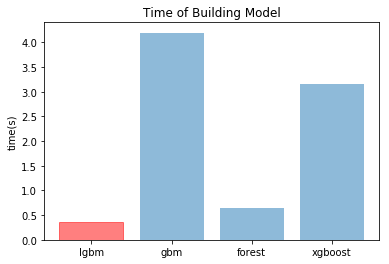

The shortest time is 0.3558 of model: lgbm


In [43]:
plot_time_comp('Time of Building Model', 'time(s)', mean_time)

std of forest auc score:  0.0413757504568
std of gbm auc score:  0.027746291638
std of xgboost auc score:  0.0232931322563
std of lightgbm auc score:  0.0287156755513


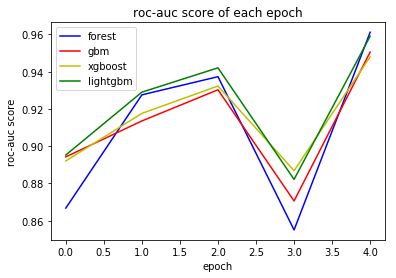

In [33]:
auc_forest = dct_scores['forest']
auc_gb = dct_scores['gbm']
auc_xgb = dct_scores['xgboost']
auc_lgb = dct_scores['lgbm']
print 'std of forest auc score: ',np.std(auc_forest)
print 'std of gbm auc score: ',np.std(auc_gb)
print 'std of xgboost auc score: ',np.std(auc_xgb)
print 'std of lightgbm auc score: ',np.std(auc_lgb)
data_source = ['roc-fold-1', 'roc-fold-2', 'roc-fold-3', 'roc-fold-4', 'roc-fold-5']
y_pos = np.arange(len(data_source))
plt.plot(y_pos, auc_forest, 'b-', label='forest')
plt.plot(y_pos, auc_gb, 'r-', label='gbm')
plt.plot(y_pos, auc_xgb, 'y-', label='xgboost')
plt.plot(y_pos, auc_lgb, 'g-', label='lightgbm')
plt.title('roc-auc score of each epoch')
plt.xlabel('epoch')
plt.ylabel('roc-auc score')
plt.legend()
plt.show()

单从5次交叉验证的各模型roc-auc得分来看，xgboost的得分相对比较稳定

### 聚合模型
由上面的模型比较可以发现，四个模型的经过交叉验证的表现都不错，但是综合而言，xgboost和lightgbm更胜一筹，而且两者的训练时间也相对更短一些，所以接下来考虑进行模型的聚合，思路如下：
* 先通过GridSearchCV分别针对四个模型在整个训练集上进行调参获得最佳的子模型
* 针对子模型使用
 * stacking: 第三方库[mlxtend](https://github.com/rasbt/mlxtend)里的stacking方法对子模型进行聚合得到聚合模型，并采用之前相同的cv方法对该模型进行打分评价
 * voting: 使用sklearn内置的VotingClassifier进行四个模型的聚合
* 最终对聚合模型在一次进行cv验证评分，根据结果确定最终的模型

先通过交叉验证针对模型选择参数组合

In [44]:
def choose_xgb_model(X_train, y_train): 
    tuned_params = [{'objective': ['binary:logistic'], 'learning_rate': [0.01, 0.03, 0.05], 
                     'n_estimators': [100, 150, 200], 'max_depth':[4, 6, 8]}]
    begin_t = time.time()
    clf = GridSearchCV(xgb.XGBClassifier(seed=7), tuned_params, scoring='roc_auc')
    clf.fit(X_train, y_train)
    end_t = time.time()
    print 'train time: ',round(end_t-begin_t, 3), 's'
    print 'current best parameters of xgboost: ',clf.best_params_
    return clf.best_estimator_

In [45]:
bst_xgb = choose_xgb_model(train_full, ytrain)

train time:  48.141 s
current best parameters of xgboost:  {'n_estimators': 150, 'objective': 'binary:logistic', 'learning_rate': 0.05, 'max_depth': 4}


In [46]:
def choose_lgb_model(X_train, y_train): 
    tuned_params = [{'objective': ['binary'], 'learning_rate': [0.01, 0.03, 0.05], 
                     'n_estimators': [100, 150, 200], 'max_depth':[4, 6, 8]}]
    begin_t = time.time()
    clf = GridSearchCV(lgb.LGBMClassifier(seed=7), tuned_params, scoring='roc_auc')
    clf.fit(X_train, y_train)
    end_t = time.time()
    print 'train time: ',round(end_t-begin_t, 3), 's'
    print 'current best parameters of lgb: ',clf.best_params_
    return clf.best_estimator_

In [47]:
bst_lgb = choose_lgb_model(train_full, ytrain)

train time:  12.543 s
current best parameters of lgb:  {'n_estimators': 150, 'objective': 'binary', 'learning_rate': 0.05, 'max_depth': 4}


先使用stacking集成两个综合表现最佳的模型lgb和xgb，此处元分类器使用较为简单的LR模型来在已经训练好了并且经过参数选择的模型上进一步优化预测结果

In [48]:
from mlxtend.classifier import StackingClassifier
from sklearn import linear_model

def stacking_model(X_train, X_test, y_train):    
    lr = linear_model.LogisticRegression(random_state=7)
    sclf = StackingClassifier(classifiers=[bst_xgb, bst_lgb], use_probas=True, average_probas=False, 
                              meta_classifier=lr)
    sclf.fit(X_train, y_train)
    predictions = sclf.predict_proba(X_test)[:, 1]
    return predictions

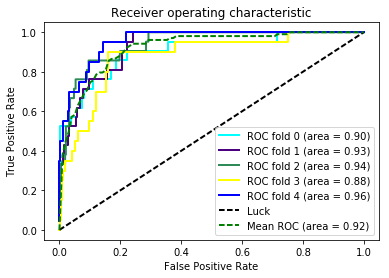

mean scores:  0.92157674772
mean model process time:  0.7022 s


In [49]:
dct_scores['stacking_1'], mean_score['stacking_1'], mean_time['stacking_1'] = kfold_plot(train_full, ytrain, stacking_model)

可以看到相对之前的得分最高的模型lightgbm，将lightgbm与xgboost经过stacking集成并且使用lr作为元分类器得到的auc得分有轻微的提升，接下来考虑进一步加入另外的RandomForest和GBDT模型看看增加一点模型的差异性使用Stacking是不是会有所提升

In [50]:
def choose_forest_model(X_train, y_train):    
    tuned_params = [{'n_estimators': [100, 150, 200], 'max_features': [8, 15, 30], 'max_depth':[4, 8, 10]}]
    begin_t = time.time()
    clf = GridSearchCV(RandomForestClassifier(random_state=7), tuned_params, scoring='roc_auc')
    clf.fit(X_train, y_train)
    end_t = time.time()
    print 'train time: ',round(end_t-begin_t, 3), 's'
    print 'current best parameters: ',clf.best_params_
    return clf.best_estimator_

In [51]:
bst_forest = choose_forest_model(train_full, ytrain)

train time:  42.201 s
current best parameters:  {'max_features': 15, 'n_estimators': 150, 'max_depth': 8}


In [52]:
def choose_gradient_model(X_train, y_train):    
    tuned_params = [{'n_estimators': [100, 150, 200], 'learning_rate': [0.03, 0.05, 0.07], 
                     'min_samples_leaf': [8, 15, 30], 'max_depth':[4, 6, 8]}]
    begin_t = time.time()
    clf = GridSearchCV(GradientBoostingClassifier(random_state=7), tuned_params, scoring='roc_auc')
    clf.fit(X_train, y_train)
    end_t = time.time()
    print 'train time: ',round(end_t-begin_t, 3), 's'
    print 'current best parameters: ',clf.best_params_
    return clf.best_estimator_

In [53]:
bst_gradient = choose_gradient_model(train_full, ytrain)

train time:  641.872 s
current best parameters:  {'n_estimators': 100, 'learning_rate': 0.03, 'max_depth': 8, 'min_samples_leaf': 30}


In [54]:
def stacking_model2(X_train, X_test, y_train):    
    lr = linear_model.LogisticRegression(random_state=7)
    sclf = StackingClassifier(classifiers=[bst_xgb, bst_forest, bst_gradient, bst_lgb], use_probas=True, 
                              average_probas=False, meta_classifier=lr)
    sclf.fit(X_train, y_train)
    predictions = sclf.predict_proba(X_test)[:, 1]
    return predictions

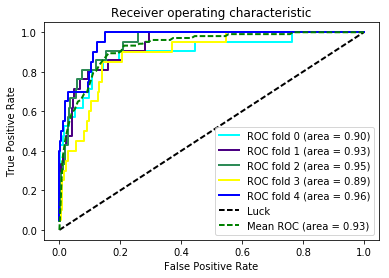

mean scores:  0.92686550152
mean model process time:  4.0878 s


In [55]:
dct_scores['stacking_2'], mean_score['stacking_2'], mean_time['stacking_2'] = kfold_plot(train_full, ytrain, stacking_model2)

可以看到四个模型的聚合效果比用两个模型的stacking聚合效果要好不少，接下来尝试使用voting对四个模型进行聚合

In [56]:
from sklearn.ensemble import VotingClassifier

def voting_model(X_train, X_test, y_train):    
    vclf = VotingClassifier(estimators=[('xgb', bst_xgb), ('rf', bst_forest), ('gbm',bst_gradient),
                                       ('lgb', bst_lgb)], voting='soft', weights=[2, 1, 1, 2])
    vclf.fit(X_train, y_train)
    predictions = vclf.predict_proba(X_test)[:, 1]
    return predictions

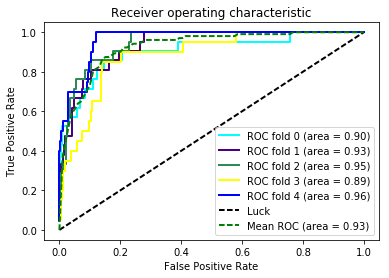

mean scores:  0.926889564336
mean model process time:  4.055 s


In [57]:
dct_scores['voting'], mean_score['voting'], mean_time['voting'] = kfold_plot(train_full, ytrain, voting_model)

再次比较单模型与集成模型的得分

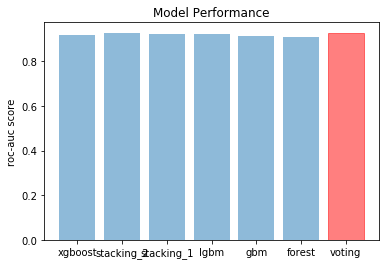

The highest auc score is 0.926889564336 of model: voting


In [58]:
plot_model_comp('Model Performance', 'roc-auc score', mean_score)

由上可以看到最终通过voting将四个模型进行聚合可以得到得分最高的模型，确定为最终用来预测的模型

### 综合模型，对测试文件进行最终预测

In [59]:
# predict(train_full, test_full, y_train)
def submit(X_train, X_test, y_train, test_ids):
    predictions = voting_model(X_train, X_test, y_train)

    sub = pd.read_csv('sampleSubmission.csv')
    result = pd.DataFrame()
    result['bidder_id'] = test_ids
    result['outcome'] = predictions
    sub = sub.merge(result, on='bidder_id', how='left')

    # Fill missing values with mean
    mean_pred = np.mean(predictions)
    sub.fillna(mean_pred, inplace=True)

    sub.drop('prediction', 1, inplace=True)
    sub.to_csv('result.csv', index=False, header=['bidder_id', 'prediction'])

In [60]:
submit(train_full, test_full, ytrain, test_ids)